# Modern Convolutional Neural Networks

In this chapter, each section corresponds to a significant CNN architecture that was at some point (or currently) the base model upon which many research projects and deployed systems were built. Each of these networks was briefly a dominant architecture and many were winners or runners-up in the ImageNet competition, which has served as a barometer of progress on supervised learning in computer vision since 2010.

## 7.1. Deep Convolutional Neural Networks (AlexNet)

### 7.1.2. AlexNet

The design philosophies of AlexNet and LeNet are very similar, but there are also significant differences. First, AlexNet is much deeper than the comparatively small LeNet5. AlexNet consists of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer. Second, AlexNet used the ReLU instead of the sigmoid as its activation function. 

#### 7.1.2.3. Capacity Control and Preprocessing

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l


def net():
    return tf.keras.models.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of
        # the output. Here, the number of output channels is much larger than
        # that in LeNet
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        tf.keras.layers.Dense(10)
    ])

### 7.1.3. Reading the Dataset

In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

4431872/4422102 [==============================] - 0s 0us/step


### 7.1.4. Training

loss 0.326, train acc 0.881, test acc 0.883
758.3 examples/sec on /GPU:0


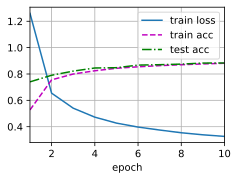

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.2. Networks Using Blocks (VGG)

### 7.2.1. VGG Blocks

The basic building block of classic CNNs is a sequence of the following: (i) a convolutional layer with padding to maintain the resolution, (ii) a nonlinearity such as a ReLU, (iii) a pooling layer such as a maximum pooling layer. One VGG block consists of a sequence of convolutional layers, followed by a maximum pooling layer for spatial downsampling.

In [5]:
import tensorflow as tf
from d2l import tensorflow as d2l

## The function takes two arguments corresponding to the number of convolutional layers num_convs and the number of output channels num_channels.
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

### 7.2.2. VGG Network

The original VGG network had 5 convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512.

In [6]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [7]:
## The following code implements VGG-11. 
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

In [8]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


### 7.2.3. Training

In [9]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
net = lambda: vgg(small_conv_arch)

loss 0.172, train acc 0.936, test acc 0.916
447.1 examples/sec on /GPU:0


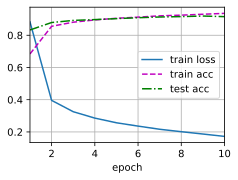

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.3. Network in Network (NiN)

### 7.3.1. NiN Blocks

In [13]:
import tensorflow as tf
from d2l import tensorflow as d2l


def nin_block(num_channels, kernel_size, strides, padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides,
                               padding=padding, activation='relu'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                               activation='relu')])

### 7.3.2. NiN Model

One significant difference between NiN and AlexNet is that NiN avoids fully-connected layers altogether. Instead, NiN uses an NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer, yielding a vector of logits. 

In [14]:
def net():
    return tf.keras.models.Sequential([
        nin_block(96, kernel_size=11, strides=4, padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Reshape((1, 1, 10)),
        # Transform the four-dimensional output into two-dimensional output
        # with a shape of (batch size, 10)
        tf.keras.layers.Flatten(),
        ])

In [15]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


### 7.3.3. Training

loss 0.330, train acc 0.878, test acc 0.879
472.3 examples/sec on /GPU:0


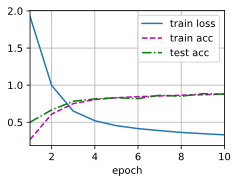

In [16]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.4. Networks with Parallel Concatenations (GoogLeNet)

### 7.4.1. Inception Blocks

In [17]:
import tensorflow as tf
from d2l import tensorflow as d2l


class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')


    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4]) 

### 7.4.2. GoogLeNet Model

GoogLeNet uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. Maximum pooling between inception blocks reduces the dimensionality. The first module is similar to AlexNet and LeNet. The stack of blocks is inherited from VGG and the global average pooling avoids a stack of fully-connected layers at the end.

The first module uses a 64-channel $7\times 7$ convolutional layer.

In [18]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
then a $3\times 3$ convolutional layer that triples the number of channels. 

In [19]:
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The third module connects two complete Inception blocks in series.


In [20]:
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The fourth module is more complicated.
It connects five Inception blocks in series.

In [22]:
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

The fifth module has two Inception blocks. The number of channels assigned to each path is the same as that in the third and fourth modules, but differs in specific values. It should be noted that the fifth block is followed by the output layer. 

In [23]:
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

In [24]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


### 7.4.3. Training

loss 0.243, train acc 0.908, test acc 0.905
548.9 examples/sec on /GPU:0


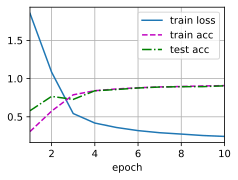

In [25]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.5. Batch Normalization

### 7.5.3. Implementation from Scratch

In [26]:
import tensorflow as tf
from d2l import tensorflow as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps):
    # Compute reciprocal of square root of the moving variance elementwise
    inv = tf.cast(tf.math.rsqrt(moving_var + eps), X.dtype)
    # Scale and shift
    inv *= gamma
    Y = X * inv + (beta - moving_mean * inv)
    return Y

In [27]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)

    def build(self, input_shape):
        weight_shape = [input_shape[-1], ]
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = self.add_weight(name='gamma', shape=weight_shape,
            initializer=tf.initializers.ones, trainable=True)
        self.beta = self.add_weight(name='beta', shape=weight_shape,
            initializer=tf.initializers.zeros, trainable=True)
        # The variables that are not model parameters are initialized to 0
        self.moving_mean = self.add_weight(name='moving_mean',
            shape=weight_shape, initializer=tf.initializers.zeros,
            trainable=False)
        self.moving_variance = self.add_weight(name='moving_variance',
            shape=weight_shape, initializer=tf.initializers.ones,
            trainable=False)
        super(BatchNorm, self).build(input_shape)

    def assign_moving_average(self, variable, value):
        momentum = 0.9
        delta = variable * momentum + value * (1 - momentum)
        return variable.assign(delta)

    @tf.function
    def call(self, inputs, training):
        if training:
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(
                inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            batch_mean = tf.squeeze(batch_mean, axes)
            batch_variance = tf.squeeze(batch_variance, axes)
            mean_update = self.assign_moving_average(
                self.moving_mean, batch_mean)
            variance_update = self.assign_moving_average(
                self.moving_variance, batch_variance)
            self.add_update(mean_update)
            self.add_update(variance_update)
            mean, variance = batch_mean, batch_variance
        else:
            mean, variance = self.moving_mean, self.moving_variance
        output = batch_norm(inputs, moving_mean=mean, moving_var=variance,
            beta=self.beta, gamma=self.gamma, eps=1e-5)
        return output

### 7.5.4. Applying Batch Normalization in LeNet

In [28]:
# Recall that this has to be a function that will be passed to `d2l.train_ch6`
# so that model building or compiling need to be within `strategy.scope()` in
# order to utilize the CPU/GPU devices that we have
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                               input_shape=(28, 28, 1)),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(10)]
    )

loss 0.284, train acc 0.894, test acc 0.885
22442.5 examples/sec on /GPU:0


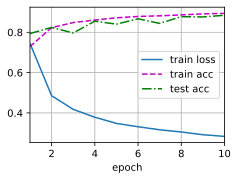

In [29]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [30]:
tf.reshape(net.layers[1].gamma, (-1,)), tf.reshape(net.layers[1].beta, (-1,))

(<tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([0.4492293 , 4.1771355 , 0.39507255, 3.7817452 , 0.43799835,
        2.7656593 ], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([-0.5796154 , -2.1556365 , -0.3255466 , -3.6409044 , -0.18366432,
        -2.8253696 ], dtype=float32)>)

In [31]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                               input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(10),
    ])

loss 0.264, train acc 0.903, test acc 0.820
29126.5 examples/sec on /GPU:0


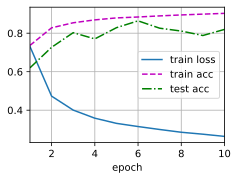

In [32]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.6. Residual Networks (ResNet)

### 7.6.2. Residual Blocks

ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together.

In [33]:
import tensorflow as tf
from d2l import tensorflow as d2l


class Residual(tf.keras.Model):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

let us look at a situation where the input and output are of the same shape.

In [34]:
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

We also have the option to halve the output height and width while increasing the number of output channels.

In [35]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

### 7.6.3. ResNet Model

The first two layers of ResNet are the same as those of the GoogLeNet: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [36]:
b1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

GoogLeNet uses four modules made up of Inception blocks. However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels.

In [37]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [38]:
b2 = ResnetBlock(64, 2, first_block=True)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

In [39]:
# Recall that we define this as a function so we can reuse later and run it
# within `tf.distribute.MirroredStrategy`'s scope to utilize various
# computational resources, e.g. GPUs. Also note that even though we have
# created b1, b2, b3, b4, b5 but we will recreate them inside this function's
# scope instead
def net():
    return tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

In [40]:
X = tf.random.uniform(shape=(1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 112, 112, 64)
BatchNormalization output shape:	 (1, 112, 112, 64)
Activation output shape:	 (1, 112, 112, 64)
MaxPooling2D output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 28, 28, 128)
ResnetBlock output shape:	 (1, 14, 14, 256)
ResnetBlock output shape:	 (1, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


### 7.6.4. Training

loss 0.005, train acc 0.999, test acc 0.923
762.8 examples/sec on /GPU:0


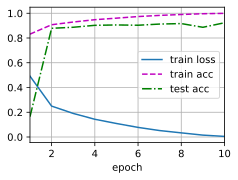

In [41]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.7. Densely Connected Networks (DenseNet)

### 7.7.1. From ResNet to DenseNet

The main components that compose a DenseNet are dense blocks and transition layers. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large.

### 7.7.2. Dense Blocks

In [42]:
import tensorflow as tf
from d2l import tensorflow as d2l


class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y

A dense block consists of multiple convolution blocks, each using the same number of output channels. In the forward propagation, however, we concatenate the input and output of each convolution block on the channel dimension.

In [43]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

In the following example, we define a DenseBlock instance with 2 convolution blocks of 10 output channels.

In [44]:
blk = DenseBlock(2, 10)
X = tf.random.uniform((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

### 7.7.3. Transition Layers

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used to control the complexity of the model. 

In [45]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)

In [46]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

### 7.7.4. DenseNet Model

In [47]:
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

Then, similar to the four modules made up of residual blocks that ResNet uses, DenseNet uses four dense blocks. 

In [48]:
def block_2():
    net = block_1()
    # `num_channels`: the current number of channels
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # This is the number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2
            net.add(TransitionBlock(num_channels))
    return net

In [49]:
def net():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net

### 7.7.5. Training

loss 0.134, train acc 0.951, test acc 0.845
991.2 examples/sec on /GPU:0


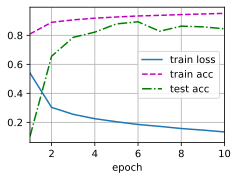

In [50]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())